<a href="https://colab.research.google.com/github/GiorgioMB/UniversityProjects/blob/main/BERT_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install libraries if necessary

In [2]:
!pip install datasets
!pip install transformers
!pip install torch torchvision torchaudio
!pip install numpy
!pip install matplotlib
!pip install hyperopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00


# Initialize dataset and model

In [17]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import torch.nn.functional as F
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [4]:
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Data preparation

In [5]:
def prepare_data(text_data, labels):
    tokenized_data = tokenizer(text_data, padding=True, truncation=True, return_tensors='pt')
    labels = torch.tensor(labels)
    dataset = TensorDataset(
        tokenized_data['input_ids'],
        tokenized_data['attention_mask'],
        labels
    )
    return dataset

train_size = int(0.8 * len(dataset['train']))
test_size = len(dataset['train']) - train_size
train_dataset = prepare_data(dataset['train']['text'], dataset['train']['label'])
validation_dataset = prepare_data(dataset['validation']['text'], dataset['validation']['label'])
new_train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])



# Hyperparameter Optimization


In [ ]:
space = {
    'lr': hp.loguniform('lr', np.log(1e-8), np.log(1e-1)),
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128])
}

n_epochs = 15
def objective(params):
    print(params)
    batch_size = int(params['batch_size'])
    train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0
        batch_n = 0
        for batch in train_loader:
            batch_n += 1
            optimizer.zero_grad()
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = F.cross_entropy(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / (len(train_loader))
        print(f"Epoch {epoch + 1}/{n_epochs} - Avg Train Loss: {avg_train_loss:.4f}")


    model.eval()
    total_test_loss = 0
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = F.cross_entropy(outputs.logits, labels)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}")
    return {'loss': avg_test_loss, 'status': STATUS_OK}

# Run the hyperparameter search
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)
best_hyperparams = {'lr': best['lr'],'batch_size': best['batch_size']}

{'batch_size': 64, 'lr': 6.914108288098731e-06}
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 0.8252
Epoch 2/15 - Avg Train Loss: 0.5131
Epoch 3/15 - Avg Train Loss: 0.3768
Epoch 4/15 - Avg Train Loss: 0.2992
Epoch 5/15 - Avg Train Loss: 0.2384
Epoch 6/15 - Avg Train Loss: 0.1726
Epoch 7/15 - Avg Train Loss: 0.1327
Epoch 8/15 - Avg Train Loss: 0.0936
Epoch 9/15 - Avg Train Loss: 0.0701
Epoch 10/15 - Avg Train Loss: 0.0549
Epoch 11/15 - Avg Train Loss: 0.0447
Epoch 12/15 - Avg Train Loss: 0.0350
Epoch 13/15 - Avg Train Loss: 0.0296
Epoch 14/15 - Avg Train Loss: 0.0292
Epoch 15/15 - Avg Train Loss: 0.0225
Test Loss: 0.6733
{'batch_size': 32, 'lr': 0.06492827596784331}
  2%|▏         | 1/50 [07:53<6:27:02, 473.93s/trial, best loss: 0.6732512881358464]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 5.1280
Epoch 2/15 - Avg Train Loss: 5.5557
Epoch 3/15 - Avg Train Loss: 6.5128
Epoch 4/15 - Avg Train Loss: 5.2934
Epoch 5/15 - Avg Train Loss: 7.5047
Epoch 6/15 - Avg Train Loss: 6.4849
Epoch 7/15 - Avg Train Loss: 5.5721
Epoch 8/15 - Avg Train Loss: 6.3956
Epoch 9/15 - Avg Train Loss: 6.0975
Epoch 10/15 - Avg Train Loss: 6.1799
Epoch 11/15 - Avg Train Loss: 6.0054
Epoch 12/15 - Avg Train Loss: 6.0198
Epoch 13/15 - Avg Train Loss: 5.6172
Epoch 14/15 - Avg Train Loss: 7.6131
Epoch 15/15 - Avg Train Loss: 5.1364
Test Loss: 6.5544
{'batch_size': 16, 'lr': 7.985966038155326e-06}
  4%|▍         | 2/50 [15:58<6:23:58, 479.97s/trial, best loss: 0.6732512881358464]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 0.6261
Epoch 2/15 - Avg Train Loss: 0.3663
Epoch 3/15 - Avg Train Loss: 0.2475
Epoch 4/15 - Avg Train Loss: 0.1544
Epoch 5/15 - Avg Train Loss: 0.0985
Epoch 6/15 - Avg Train Loss: 0.0640
Epoch 7/15 - Avg Train Loss: 0.0512
Epoch 8/15 - Avg Train Loss: 0.0456
Epoch 9/15 - Avg Train Loss: 0.0320
Epoch 10/15 - Avg Train Loss: 0.0252
Epoch 11/15 - Avg Train Loss: 0.0259
Epoch 12/15 - Avg Train Loss: 0.0228
Epoch 13/15 - Avg Train Loss: 0.0217
Epoch 14/15 - Avg Train Loss: 0.0172
Epoch 15/15 - Avg Train Loss: 0.0130
Test Loss: 0.7924
{'batch_size': 64, 'lr': 1.8205868806001222e-06}
  6%|▌         | 3/50 [25:25<6:47:04, 519.68s/trial, best loss: 0.6732512881358464]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 0.9438
Epoch 2/15 - Avg Train Loss: 0.8475
Epoch 3/15 - Avg Train Loss: 0.7446
Epoch 4/15 - Avg Train Loss: 0.6500
Epoch 5/15 - Avg Train Loss: 0.5776
Epoch 6/15 - Avg Train Loss: 0.5089
Epoch 7/15 - Avg Train Loss: 0.4492
Epoch 8/15 - Avg Train Loss: 0.4113
Epoch 9/15 - Avg Train Loss: 0.3811
Epoch 10/15 - Avg Train Loss: 0.3519
Epoch 11/15 - Avg Train Loss: 0.3191
Epoch 12/15 - Avg Train Loss: 0.2961
Epoch 13/15 - Avg Train Loss: 0.2689
Epoch 14/15 - Avg Train Loss: 0.2520
Epoch 15/15 - Avg Train Loss: 0.2320
Test Loss: 0.4280
{'batch_size': 64, 'lr': 7.871839021193676e-06}
  8%|▊         | 4/50 [32:58<6:18:16, 493.40s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 0.7620
Epoch 2/15 - Avg Train Loss: 0.4701
Epoch 3/15 - Avg Train Loss: 0.3552
Epoch 4/15 - Avg Train Loss: 0.2622
Epoch 5/15 - Avg Train Loss: 0.2019
Epoch 6/15 - Avg Train Loss: 0.1522
Epoch 7/15 - Avg Train Loss: 0.1125
Epoch 8/15 - Avg Train Loss: 0.0813
Epoch 9/15 - Avg Train Loss: 0.0595
Epoch 10/15 - Avg Train Loss: 0.0494
Epoch 11/15 - Avg Train Loss: 0.0361
Epoch 12/15 - Avg Train Loss: 0.0371
Epoch 13/15 - Avg Train Loss: 0.0353
Epoch 14/15 - Avg Train Loss: 0.0239
Epoch 15/15 - Avg Train Loss: 0.0192
Test Loss: 0.6569
{'batch_size': 128, 'lr': 0.0002106233907231182}
 10%|█         | 5/50 [40:31<5:59:07, 478.83s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 0.6804
Epoch 2/15 - Avg Train Loss: 0.3330
Epoch 3/15 - Avg Train Loss: 0.1668
Epoch 4/15 - Avg Train Loss: 0.1052
Epoch 5/15 - Avg Train Loss: 0.0670
Epoch 6/15 - Avg Train Loss: 0.0607
Epoch 7/15 - Avg Train Loss: 0.0526
Epoch 8/15 - Avg Train Loss: 0.0516
Epoch 9/15 - Avg Train Loss: 0.0439
Epoch 10/15 - Avg Train Loss: 0.0418
Epoch 11/15 - Avg Train Loss: 0.0361
Epoch 12/15 - Avg Train Loss: 0.0301
Epoch 13/15 - Avg Train Loss: 0.0502
Epoch 14/15 - Avg Train Loss: 0.0710
Epoch 15/15 - Avg Train Loss: 0.1224
Test Loss: 0.9135
{'batch_size': 128, 'lr': 0.0026945774620577533}
 12%|█▏        | 6/50 [47:42<5:39:13, 462.59s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 1.0487
Epoch 2/15 - Avg Train Loss: 0.9153
Epoch 3/15 - Avg Train Loss: 0.9314
Epoch 4/15 - Avg Train Loss: 0.9127
Epoch 5/15 - Avg Train Loss: 0.9256
Epoch 6/15 - Avg Train Loss: 0.9045
Epoch 7/15 - Avg Train Loss: 0.9322
Epoch 8/15 - Avg Train Loss: 0.9199
Epoch 9/15 - Avg Train Loss: 0.9143
Epoch 10/15 - Avg Train Loss: 0.9231
Epoch 11/15 - Avg Train Loss: 0.9183
Epoch 12/15 - Avg Train Loss: 0.9387
Epoch 13/15 - Avg Train Loss: 0.9365
Epoch 14/15 - Avg Train Loss: 0.9211
Epoch 15/15 - Avg Train Loss: 0.9277
Test Loss: 0.9345
{'batch_size': 128, 'lr': 5.652935180045177e-07}
 14%|█▍        | 7/50 [54:53<5:24:05, 452.23s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 0.9909
Epoch 2/15 - Avg Train Loss: 0.9488
Epoch 3/15 - Avg Train Loss: 0.9201
Epoch 4/15 - Avg Train Loss: 0.8953
Epoch 5/15 - Avg Train Loss: 0.8738
Epoch 6/15 - Avg Train Loss: 0.8517
Epoch 7/15 - Avg Train Loss: 0.8271
Epoch 8/15 - Avg Train Loss: 0.8009
Epoch 9/15 - Avg Train Loss: 0.7723
Epoch 10/15 - Avg Train Loss: 0.7452
Epoch 11/15 - Avg Train Loss: 0.7229
Epoch 12/15 - Avg Train Loss: 0.6994
Epoch 13/15 - Avg Train Loss: 0.6855
Epoch 14/15 - Avg Train Loss: 0.6685
Epoch 15/15 - Avg Train Loss: 0.6507
Test Loss: 0.6527
{'batch_size': 16, 'lr': 3.167454375820813e-05}
 16%|█▌        | 8/50 [1:02:04<5:11:53, 445.56s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 0.5325
Epoch 2/15 - Avg Train Loss: 0.2496
Epoch 3/15 - Avg Train Loss: 0.1218
Epoch 4/15 - Avg Train Loss: 0.0740
Epoch 5/15 - Avg Train Loss: 0.0571
Epoch 6/15 - Avg Train Loss: 0.0416
Epoch 7/15 - Avg Train Loss: 0.0404
Epoch 8/15 - Avg Train Loss: 0.0303
Epoch 9/15 - Avg Train Loss: 0.0289
Epoch 10/15 - Avg Train Loss: 0.0230
Epoch 11/15 - Avg Train Loss: 0.0214
Epoch 12/15 - Avg Train Loss: 0.0264
Epoch 13/15 - Avg Train Loss: 0.0239
Epoch 14/15 - Avg Train Loss: 0.0127
Epoch 15/15 - Avg Train Loss: 0.0195
Test Loss: 0.9543
{'batch_size': 128, 'lr': 8.88545482571064e-08}
 18%|█▊        | 9/50 [1:11:31<5:30:19, 483.41s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 1.2641
Epoch 2/15 - Avg Train Loss: 1.2419
Epoch 3/15 - Avg Train Loss: 1.2153
Epoch 4/15 - Avg Train Loss: 1.1904
Epoch 5/15 - Avg Train Loss: 1.1553
Epoch 6/15 - Avg Train Loss: 1.1195
Epoch 7/15 - Avg Train Loss: 1.0846
Epoch 8/15 - Avg Train Loss: 1.0527
Epoch 9/15 - Avg Train Loss: 1.0221
Epoch 10/15 - Avg Train Loss: 1.0022
Epoch 11/15 - Avg Train Loss: 0.9814
Epoch 12/15 - Avg Train Loss: 0.9650
Epoch 13/15 - Avg Train Loss: 0.9537
Epoch 14/15 - Avg Train Loss: 0.9402
Epoch 15/15 - Avg Train Loss: 0.9319
Test Loss: 0.9120
{'batch_size': 32, 'lr': 1.0836937702590554e-07}
 20%|██        | 10/50 [1:18:41<5:11:28, 467.20s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 0.9996
Epoch 2/15 - Avg Train Loss: 0.9520
Epoch 3/15 - Avg Train Loss: 0.9273
Epoch 4/15 - Avg Train Loss: 0.9088
Epoch 5/15 - Avg Train Loss: 0.9017
Epoch 6/15 - Avg Train Loss: 0.8952
Epoch 7/15 - Avg Train Loss: 0.8931
Epoch 8/15 - Avg Train Loss: 0.8874
Epoch 9/15 - Avg Train Loss: 0.8800
Epoch 10/15 - Avg Train Loss: 0.8750
Epoch 11/15 - Avg Train Loss: 0.8682
Epoch 12/15 - Avg Train Loss: 0.8608
Epoch 13/15 - Avg Train Loss: 0.8515
Epoch 14/15 - Avg Train Loss: 0.8382
Epoch 15/15 - Avg Train Loss: 0.8229
Test Loss: 0.8023
{'batch_size': 16, 'lr': 0.003291576950124041}
 22%|██▏       | 11/50 [1:26:46<5:07:12, 472.62s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 1.0563
Epoch 2/15 - Avg Train Loss: 1.0431
Epoch 3/15 - Avg Train Loss: 1.0270
Epoch 4/15 - Avg Train Loss: 1.0259
Epoch 5/15 - Avg Train Loss: 1.0389
Epoch 6/15 - Avg Train Loss: 1.0349
Epoch 7/15 - Avg Train Loss: 1.0613
Epoch 8/15 - Avg Train Loss: 1.0586
Epoch 9/15 - Avg Train Loss: 1.0477
Epoch 10/15 - Avg Train Loss: 1.0718
Epoch 11/15 - Avg Train Loss: 1.0871
Epoch 12/15 - Avg Train Loss: 1.0460
Epoch 13/15 - Avg Train Loss: 1.0813
Epoch 14/15 - Avg Train Loss: 1.0516
Epoch 15/15 - Avg Train Loss: 1.0787
Test Loss: 2.1855
{'batch_size': 16, 'lr': 0.0026365042397011756}
 24%|██▍       | 12/50 [1:36:12<5:17:19, 501.05s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 1.0039
Epoch 2/15 - Avg Train Loss: 1.0199
Epoch 3/15 - Avg Train Loss: 1.0501
Epoch 4/15 - Avg Train Loss: 1.0468
Epoch 5/15 - Avg Train Loss: 1.0339
Epoch 6/15 - Avg Train Loss: 1.0163
Epoch 7/15 - Avg Train Loss: 1.0131
Epoch 8/15 - Avg Train Loss: 0.9984
Epoch 9/15 - Avg Train Loss: 1.0073
Epoch 10/15 - Avg Train Loss: 1.0097
Epoch 11/15 - Avg Train Loss: 1.0257
Epoch 12/15 - Avg Train Loss: 1.0790
Epoch 13/15 - Avg Train Loss: 1.0176
Epoch 14/15 - Avg Train Loss: 1.0229
Epoch 15/15 - Avg Train Loss: 1.0254
Test Loss: 0.9234
{'batch_size': 32, 'lr': 0.011865633306493982}
 26%|██▌       | 13/50 [1:45:38<5:21:01, 520.58s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 1.3908
Epoch 2/15 - Avg Train Loss: 1.1807
Epoch 3/15 - Avg Train Loss: 1.1711
Epoch 4/15 - Avg Train Loss: 1.1865
Epoch 5/15 - Avg Train Loss: 1.1707
Epoch 6/15 - Avg Train Loss: 1.2836
Epoch 7/15 - Avg Train Loss: 1.3129
Epoch 8/15 - Avg Train Loss: 1.1304
Epoch 9/15 - Avg Train Loss: 1.1129
Epoch 10/15 - Avg Train Loss: 1.3613
Epoch 11/15 - Avg Train Loss: 1.2215
Epoch 12/15 - Avg Train Loss: 1.1779
Epoch 13/15 - Avg Train Loss: 1.4005
Epoch 14/15 - Avg Train Loss: 1.3174
Epoch 15/15 - Avg Train Loss: 1.3413
Test Loss: 1.3496
{'batch_size': 32, 'lr': 0.003941573815185627}
 28%|██▊       | 14/50 [1:53:42<5:05:48, 509.67s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 1.0864
Epoch 2/15 - Avg Train Loss: 1.0231
Epoch 3/15 - Avg Train Loss: 1.0021
Epoch 4/15 - Avg Train Loss: 1.0084
Epoch 5/15 - Avg Train Loss: 0.9830
Epoch 6/15 - Avg Train Loss: 0.9903
Epoch 7/15 - Avg Train Loss: 1.0400
Epoch 8/15 - Avg Train Loss: 1.0078
Epoch 9/15 - Avg Train Loss: 0.9908
Epoch 10/15 - Avg Train Loss: 0.9867
Epoch 11/15 - Avg Train Loss: 0.9932
Epoch 12/15 - Avg Train Loss: 1.0100
Epoch 13/15 - Avg Train Loss: 1.0053
Epoch 14/15 - Avg Train Loss: 0.9808
Epoch 15/15 - Avg Train Loss: 1.0054
Test Loss: 0.9931
{'batch_size': 64, 'lr': 0.08903453304470907}
 30%|███       | 15/50 [2:01:47<4:52:50, 502.01s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 11.2922
Epoch 2/15 - Avg Train Loss: 7.3329
Epoch 3/15 - Avg Train Loss: 8.0316
Epoch 4/15 - Avg Train Loss: 11.2786
Epoch 5/15 - Avg Train Loss: 7.8200
Epoch 6/15 - Avg Train Loss: 7.5973
Epoch 7/15 - Avg Train Loss: 8.6730
Epoch 8/15 - Avg Train Loss: 10.3527
Epoch 9/15 - Avg Train Loss: 10.4878
Epoch 10/15 - Avg Train Loss: 10.3263
Epoch 11/15 - Avg Train Loss: 9.9260
Epoch 12/15 - Avg Train Loss: 6.9484
Epoch 13/15 - Avg Train Loss: 4.6914
Epoch 14/15 - Avg Train Loss: 9.8628
Epoch 15/15 - Avg Train Loss: 7.9434
Test Loss: 6.7387
{'batch_size': 128, 'lr': 0.08816839638909872}
 32%|███▏      | 16/50 [2:09:19<4:36:01, 487.10s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 12.6424
Epoch 2/15 - Avg Train Loss: 8.3849
Epoch 3/15 - Avg Train Loss: 9.4689
Epoch 4/15 - Avg Train Loss: 8.4006
Epoch 5/15 - Avg Train Loss: 6.5962
Epoch 6/15 - Avg Train Loss: 9.5719
Epoch 7/15 - Avg Train Loss: 6.5564
Epoch 8/15 - Avg Train Loss: 8.9620
Epoch 9/15 - Avg Train Loss: 9.0184
Epoch 10/15 - Avg Train Loss: 10.7772
Epoch 11/15 - Avg Train Loss: 11.5229
Epoch 12/15 - Avg Train Loss: 7.7213
Epoch 13/15 - Avg Train Loss: 10.6614
Epoch 14/15 - Avg Train Loss: 19.0304
Epoch 15/15 - Avg Train Loss: 12.1953
Test Loss: 7.1069
{'batch_size': 64, 'lr': 7.97371579406517e-05}
 34%|███▍      | 17/50 [2:16:28<4:18:16, 469.60s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 0.5770
Epoch 2/15 - Avg Train Loss: 0.2853
Epoch 3/15 - Avg Train Loss: 0.1292
Epoch 4/15 - Avg Train Loss: 0.0758
Epoch 5/15 - Avg Train Loss: 0.0544
Epoch 6/15 - Avg Train Loss: 0.0469
Epoch 7/15 - Avg Train Loss: 0.0402
Epoch 8/15 - Avg Train Loss: 0.0244
Epoch 9/15 - Avg Train Loss: 0.0212
Epoch 10/15 - Avg Train Loss: 0.0298
Epoch 11/15 - Avg Train Loss: 0.0167
Epoch 12/15 - Avg Train Loss: 0.0350
Epoch 13/15 - Avg Train Loss: 0.0168
Epoch 14/15 - Avg Train Loss: 0.0158
Epoch 15/15 - Avg Train Loss: 0.0221
Test Loss: 0.7177
{'batch_size': 16, 'lr': 0.00036066824364238174}
 36%|███▌      | 18/50 [2:24:02<4:07:57, 464.91s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 0.9124
Epoch 2/15 - Avg Train Loss: 0.8970
Epoch 3/15 - Avg Train Loss: 0.8970
Epoch 4/15 - Avg Train Loss: 0.8974
Epoch 5/15 - Avg Train Loss: 0.8963
Epoch 6/15 - Avg Train Loss: 0.8948
Epoch 7/15 - Avg Train Loss: 0.8951
Epoch 8/15 - Avg Train Loss: 0.8936
Epoch 9/15 - Avg Train Loss: 0.8933
Epoch 10/15 - Avg Train Loss: 0.8940
Epoch 11/15 - Avg Train Loss: 0.8944
Epoch 12/15 - Avg Train Loss: 0.8946
Epoch 13/15 - Avg Train Loss: 0.8934
Epoch 14/15 - Avg Train Loss: 0.8930
Epoch 15/15 - Avg Train Loss: 0.8928
Test Loss: 0.8941
{'batch_size': 64, 'lr': 1.064896354040468e-05}
 38%|███▊      | 19/50 [2:33:28<4:15:51, 495.22s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 0.7196
Epoch 2/15 - Avg Train Loss: 0.4160
Epoch 3/15 - Avg Train Loss: 0.2968
Epoch 4/15 - Avg Train Loss: 0.2054
Epoch 5/15 - Avg Train Loss: 0.1357
Epoch 6/15 - Avg Train Loss: 0.0934
Epoch 7/15 - Avg Train Loss: 0.0637
Epoch 8/15 - Avg Train Loss: 0.0497
Epoch 9/15 - Avg Train Loss: 0.0390
Epoch 10/15 - Avg Train Loss: 0.0331
Epoch 11/15 - Avg Train Loss: 0.0289
Epoch 12/15 - Avg Train Loss: 0.0207
Epoch 13/15 - Avg Train Loss: 0.0161
Epoch 14/15 - Avg Train Loss: 0.0232
Epoch 15/15 - Avg Train Loss: 0.0264
Test Loss: 0.7064
{'batch_size': 128, 'lr': 1.0677037021819624e-06}
 40%|████      | 20/50 [2:41:01<4:01:19, 482.64s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 1.0302
Epoch 2/15 - Avg Train Loss: 0.9373
Epoch 3/15 - Avg Train Loss: 0.8994
Epoch 4/15 - Avg Train Loss: 0.8830
Epoch 5/15 - Avg Train Loss: 0.8641
Epoch 6/15 - Avg Train Loss: 0.8328
Epoch 7/15 - Avg Train Loss: 0.7871
Epoch 8/15 - Avg Train Loss: 0.7292
Epoch 9/15 - Avg Train Loss: 0.6687
Epoch 10/15 - Avg Train Loss: 0.6168
Epoch 11/15 - Avg Train Loss: 0.5711
Epoch 12/15 - Avg Train Loss: 0.5407
Epoch 13/15 - Avg Train Loss: 0.5059
Epoch 14/15 - Avg Train Loss: 0.4800
Epoch 15/15 - Avg Train Loss: 0.4536
Test Loss: 0.4922
{'batch_size': 128, 'lr': 1.5280710312528344e-08}
 42%|████▏     | 21/50 [2:48:13<3:45:50, 467.26s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 1.2504
Epoch 2/15 - Avg Train Loss: 1.2454
Epoch 3/15 - Avg Train Loss: 1.2408
Epoch 4/15 - Avg Train Loss: 1.2381
Epoch 5/15 - Avg Train Loss: 1.2333
Epoch 6/15 - Avg Train Loss: 1.2320
Epoch 7/15 - Avg Train Loss: 1.2273
Epoch 8/15 - Avg Train Loss: 1.2236
Epoch 9/15 - Avg Train Loss: 1.2189
Epoch 10/15 - Avg Train Loss: 1.2148
Epoch 11/15 - Avg Train Loss: 1.2095
Epoch 12/15 - Avg Train Loss: 1.2063
Epoch 13/15 - Avg Train Loss: 1.2050
Epoch 14/15 - Avg Train Loss: 1.2004
Epoch 15/15 - Avg Train Loss: 1.1971
Test Loss: 1.1964
{'batch_size': 64, 'lr': 1.0981890569822002e-06}
 44%|████▍     | 22/50 [2:55:24<3:32:58, 456.39s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 1.0120
Epoch 2/15 - Avg Train Loss: 0.8967
Epoch 3/15 - Avg Train Loss: 0.8635
Epoch 4/15 - Avg Train Loss: 0.7855
Epoch 5/15 - Avg Train Loss: 0.6881
Epoch 6/15 - Avg Train Loss: 0.6269
Epoch 7/15 - Avg Train Loss: 0.5855
Epoch 8/15 - Avg Train Loss: 0.5282
Epoch 9/15 - Avg Train Loss: 0.4847
Epoch 10/15 - Avg Train Loss: 0.4527
Epoch 11/15 - Avg Train Loss: 0.4281
Epoch 12/15 - Avg Train Loss: 0.4018
Epoch 13/15 - Avg Train Loss: 0.3823
Epoch 14/15 - Avg Train Loss: 0.3674
Epoch 15/15 - Avg Train Loss: 0.3509
Test Loss: 0.4650
{'batch_size': 64, 'lr': 1.0490808481579257e-06}
 46%|████▌     | 23/50 [3:02:57<3:24:59, 455.54s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 1.0343
Epoch 2/15 - Avg Train Loss: 0.8924
Epoch 3/15 - Avg Train Loss: 0.8561
Epoch 4/15 - Avg Train Loss: 0.8084
Epoch 5/15 - Avg Train Loss: 0.7299
Epoch 6/15 - Avg Train Loss: 0.6415
Epoch 7/15 - Avg Train Loss: 0.5787
Epoch 8/15 - Avg Train Loss: 0.5275
Epoch 9/15 - Avg Train Loss: 0.4943
Epoch 10/15 - Avg Train Loss: 0.4636
Epoch 11/15 - Avg Train Loss: 0.4390
Epoch 12/15 - Avg Train Loss: 0.4175
Epoch 13/15 - Avg Train Loss: 0.4006
Epoch 14/15 - Avg Train Loss: 0.3864
Epoch 15/15 - Avg Train Loss: 0.3650
Test Loss: 0.4434
{'batch_size': 64, 'lr': 2.48019286578671e-08}
 48%|████▊     | 24/50 [3:10:30<3:17:05, 454.84s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 1.4628
Epoch 2/15 - Avg Train Loss: 1.4397
Epoch 3/15 - Avg Train Loss: 1.4177
Epoch 4/15 - Avg Train Loss: 1.3972
Epoch 5/15 - Avg Train Loss: 1.3745
Epoch 6/15 - Avg Train Loss: 1.3543
Epoch 7/15 - Avg Train Loss: 1.3344
Epoch 8/15 - Avg Train Loss: 1.3161
Epoch 9/15 - Avg Train Loss: 1.2976
Epoch 10/15 - Avg Train Loss: 1.2807
Epoch 11/15 - Avg Train Loss: 1.2604
Epoch 12/15 - Avg Train Loss: 1.2428
Epoch 13/15 - Avg Train Loss: 1.2257
Epoch 14/15 - Avg Train Loss: 1.2124
Epoch 15/15 - Avg Train Loss: 1.1929
Test Loss: 1.1743
{'batch_size': 64, 'lr': 2.46852661594772e-07}
 50%|█████     | 25/50 [3:18:04<3:09:20, 454.40s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 1.1237
Epoch 2/15 - Avg Train Loss: 1.0349
Epoch 3/15 - Avg Train Loss: 0.9601
Epoch 4/15 - Avg Train Loss: 0.9213
Epoch 5/15 - Avg Train Loss: 0.9031
Epoch 6/15 - Avg Train Loss: 0.8933
Epoch 7/15 - Avg Train Loss: 0.8854
Epoch 8/15 - Avg Train Loss: 0.8818
Epoch 9/15 - Avg Train Loss: 0.8734
Epoch 10/15 - Avg Train Loss: 0.8670
Epoch 11/15 - Avg Train Loss: 0.8607
Epoch 12/15 - Avg Train Loss: 0.8511
Epoch 13/15 - Avg Train Loss: 0.8452
Epoch 14/15 - Avg Train Loss: 0.8335
Epoch 15/15 - Avg Train Loss: 0.8224
Test Loss: 0.7991
{'batch_size': 64, 'lr': 2.115641375396176e-06}
 52%|█████▏    | 26/50 [3:25:37<3:01:34, 453.95s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 1.0271
Epoch 2/15 - Avg Train Loss: 0.8475
Epoch 3/15 - Avg Train Loss: 0.7330
Epoch 4/15 - Avg Train Loss: 0.5958
Epoch 5/15 - Avg Train Loss: 0.5040
Epoch 6/15 - Avg Train Loss: 0.4523
Epoch 7/15 - Avg Train Loss: 0.4085
Epoch 8/15 - Avg Train Loss: 0.3750
Epoch 9/15 - Avg Train Loss: 0.3490
Epoch 10/15 - Avg Train Loss: 0.3165
Epoch 11/15 - Avg Train Loss: 0.2981
Epoch 12/15 - Avg Train Loss: 0.2731
Epoch 13/15 - Avg Train Loss: 0.2472
Epoch 14/15 - Avg Train Loss: 0.2282
Epoch 15/15 - Avg Train Loss: 0.2102
Test Loss: 0.4343
{'batch_size': 64, 'lr': 2.348754728574911e-06}
 54%|█████▍    | 27/50 [3:33:09<2:53:52, 453.59s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 0.8919
Epoch 2/15 - Avg Train Loss: 0.7813
Epoch 3/15 - Avg Train Loss: 0.6253
Epoch 4/15 - Avg Train Loss: 0.5240
Epoch 5/15 - Avg Train Loss: 0.4632
Epoch 6/15 - Avg Train Loss: 0.4203
Epoch 7/15 - Avg Train Loss: 0.3839
Epoch 8/15 - Avg Train Loss: 0.3492
Epoch 9/15 - Avg Train Loss: 0.3148
Epoch 10/15 - Avg Train Loss: 0.2921
Epoch 11/15 - Avg Train Loss: 0.2650
Epoch 12/15 - Avg Train Loss: 0.2363
Epoch 13/15 - Avg Train Loss: 0.2137
Epoch 14/15 - Avg Train Loss: 0.1912
Epoch 15/15 - Avg Train Loss: 0.1797
Test Loss: 0.4356
{'batch_size': 64, 'lr': 5.12364341296633e-08}
 56%|█████▌    | 28/50 [3:40:42<2:46:12, 453.31s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 1.0018
Epoch 2/15 - Avg Train Loss: 0.9798
Epoch 3/15 - Avg Train Loss: 0.9652
Epoch 4/15 - Avg Train Loss: 0.9518
Epoch 5/15 - Avg Train Loss: 0.9442
Epoch 6/15 - Avg Train Loss: 0.9348
Epoch 7/15 - Avg Train Loss: 0.9275
Epoch 8/15 - Avg Train Loss: 0.9195
Epoch 9/15 - Avg Train Loss: 0.9186
Epoch 10/15 - Avg Train Loss: 0.9168
Epoch 11/15 - Avg Train Loss: 0.9122
Epoch 12/15 - Avg Train Loss: 0.9061
Epoch 13/15 - Avg Train Loss: 0.9054
Epoch 14/15 - Avg Train Loss: 0.8997
Epoch 15/15 - Avg Train Loss: 0.8975
Test Loss: 0.8836
{'batch_size': 64, 'lr': 2.9786267607470736e-06}
 58%|█████▊    | 29/50 [3:48:15<2:38:36, 453.15s/trial, best loss: 0.4279651741186778]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Avg Train Loss: 0.8524
 58%|█████▊    | 29/50 [3:48:46<2:38:36, 453.15s/trial, best loss: 0.4279651741186778]

In [ ]:
print(best_hyperparams)

In [1]:
best_hyperparams = {'batch_size': 64, 'lr': 1.8205868806001222e-06}

# Cross Validation

In [6]:
n_folds = 5
kf = KFold(n_splits=n_folds)
fold_loss = []
fold_accuracy = []
confusion_matrices = []
n_epochs = 20

for fold, (train_index, val_index) in enumerate(kf.split(train_dataset)):
    print(f"Training on fold {fold+1}/{n_folds}")
    train_subset = torch.utils.data.Subset(train_dataset, train_index)
    train_loader = DataLoader(train_subset, batch_size=best_hyperparams['batch_size'], shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=best_hyperparams['batch_size'], shuffle=True)
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    optimizer = torch.optim.AdamW(model.parameters(), lr=best_hyperparams['lr'])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Training loop
    for epoch in range(n_epochs):  # Adjust the number of epochs as needed
        model.train()
        total_train_accuracy = 0
        total_train_examples = 0
        for batch in train_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = F.cross_entropy(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs.logits, dim=1)
            correct_preds = (preds == labels).float()
            total_train_accuracy += correct_preds.sum().item()
            total_train_examples += labels.size(0)


    # Validation loop
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    all_preds = []
    all_labels = []
    for batch in validation_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = F.cross_entropy(outputs.logits, labels)
            total_eval_loss += loss.item()
            _, preds = torch.max(outputs.logits, dim=1)
            correct_preds = (preds == labels).float()
            total_eval_accuracy += correct_preds.sum()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    avg_val_loss = total_eval_loss / len(validation_loader)
    avg_val_accuracy = total_eval_accuracy / len(validation_loader)
    fold_loss.append(avg_val_loss)
    fold_accuracy.append(avg_val_accuracy)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    cm = confusion_matrix(all_labels, all_preds)
    confusion_matrices.append(cm)



Training on fold 1/5


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on fold 2/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on fold 3/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on fold 4/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on fold 5/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##Visualization

**Confusion Matrices**

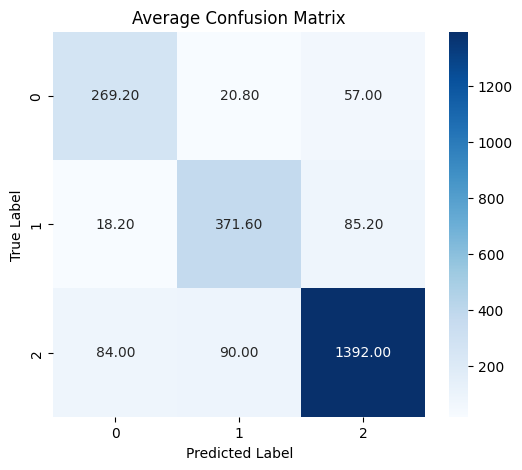

In [18]:
average_cm = sum(confusion_matrices) / len(confusion_matrices)

# Plotting the average confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(average_cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Average Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [22]:
tot_cm = sum(confusion_matrices)
TP = np.diag(tot_cm)
FP  = np.sum(tot_cm, axis=0) - TP
FN = np.sum(tot_cm, axis=1) - TP

precision = TP / (TP + FP)
recall = TP / (TP + FN)

f1_scores = 2 * (precision* recall) / (precision + recall)

average_f1_score = np.mean(f1_scores)
average_precision = np.mean(precision)
average_recall = np.mean(recall)

print("Average F1:", average_f1_score)
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average F1: 0.8079062831302043
Average Precision: 0.8008177784906451
Average Recall: 0.8156657285223946


# Save

In [ ]:
save_path = '/content/drive/MyDrive/models'


In [ ]:
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
